## Sequential FDP with proxy models

#### Load modules

In [6]:
%load_ext autoreload
%autoreload 2

import os.path
import pickle

from sampler import DataSampling
from proxymodel import ProxyModel
from optimization import GlobalOpt
from utils import load_matfile
import argparse
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set parameters

In [7]:
parser = argparse.ArgumentParser()

args, unknown = parser.parse_known_args()

args.filepath = 'data'
args.simulation_directory = 'simulation'
args.save_directory = 'variables'
args.ecl_filename = '2D_JY_Eclrun'
args.frs_filename = '2D_JY_Frsrun'
args.perm_filename = '2D_PERMX'
args.position_filename = '2D_POSITION'
args.constraint_filename = '2D_CONSTRAINT'

args.independent_area = 40  # acre
args.num_of_x = 60
args.num_of_y = 60
args.num_of_z = 1
args.num_of_max_well = 14
args.num_of_rigs = 3
args.num_of_particles = 3
args.length_of_x = 120
args.length_of_y = 120
args.length_of_z = 120
args.num_of_ensemble = 10

args.discount_rate = 0.1
args.observed_term = 30
args.discount_term = 365
args.oil_price = 60
args.injection_cost = -5
args.disposal_cost = -3
args.drilling_cost = 0

args.production_time = 7200
args.tstep = 30
args.dstep = 90  # drilling span
args.streamline_time = 30
args.max_tof = 10000
args.max_pressure = 3500
args.res_oilsat = 0.2

args.num_of_train_sample = 500
args.train_ratio = 0.7
args.validate_ratio = 0.15
args.train_model_saved_dir_super = './model'
args.train_model_saved_dir = './model/1'
args.span_of_retrain = 20

args.ratio_of_infeasible = 0.3
args.well_type = {'P': 1, 'No': 0, 'I': -1}
args.type_fix = False
args.drilling_time_fix = True
args.location_fix = True
args.control_fix = True

args.well_placement_optimization = True
args.well_operation_optimization = True
args.simultaneous_optimization = False
args.well_location_index = None
args.well_type_real = None
args.well_placement_wset = [1500, 1500, 5500, 5500]
args.well_operation_wset = [1500, 2500, 4500, 6000]

args.perm_mat = './data/PERMX.mat'

args.parallel = True

args.cached_dir = './cached'
args.well_placement_sample_file = 'sample_wp(5).pkl'
args.well_operation_sample_file = 'sample_wo(5).pkl'
args.num_of_epochs = 20
args.batch_size = 150

args.optimization_algorithm = 'PSO'
args.num_of_generations = 200

args.gen_of_retrain = range(args.span_of_retrain, args.num_of_generations + 1, args.span_of_retrain)

assert args.validate_ratio != 0, 'validate_ratio should be greater than 0'
assert (1 - args.train_ratio - args.validate_ratio) > 0, '(train_ratio + validate_ratio) should not be 1'
if args.well_operation_optimization and not args.well_placement_optimization:
    # if you only want to optimize well operation conditions, provide well position settings by yourself
    assert args.well_placement_optimization, 'if you only want to optimize well operation conditions, provide ' \
                                             'well position settings by yourself. You must set the default well ' \
                                             'locations for a defined number of wells. ' \
                                             '- well_location_index, well_type_real'

In [8]:
if not os.path.exists(args.train_model_saved_dir):
    if not os.path.exists(args.train_model_saved_dir_super):
        print('model_saved_dir not exists')
        os.mkdir(args.train_model_saved_dir_super)
        os.mkdir(args.train_model_saved_dir)

perm = load_matfile(args.perm_mat, 'original')
perm_idx = load_matfile(args.perm_mat, 'selected')


### 1. Well placement


#### 1.1. Proxy modeling


##### make samples to train a proxy model

In [9]:
args.independent_area = 40
args.num_of_train_sample = 500
args.well_placement_wset = [1500, 1500, 5500, 5500]
args.well_type = {'P': 1, 'No': 0, 'I': -1}
args.ratio_of_infeasible = 0.3

In [10]:
PlacementSample = DataSampling(args, wset=args.well_placement_wset, well_type=args.well_type,
                                       location_fix=False, type_fix=False, drilling_time_fix=True,
                                       control_fix=True, num_of_ensemble=args.num_of_ensemble,
                                       num_of_wells=args.num_of_max_well)

if os.path.exists(os.path.join(args.cached_dir, args.well_placement_sample_file)):
    with open(os.path.join(args.cached_dir, args.well_placement_sample_file), 'rb') as f:
        samples_p = pickle.load(f)
else:
    samples_p = []
    for idx in range(args.num_of_ensemble):
        print(f'ensemble #{idx + 1}')
        initial_p = PlacementSample.make_candidate_solutions(num_of_candidates=args.num_of_train_sample)
        samples_p += PlacementSample.make_train_data(initial_p, [perm[perm_idx[idx][0] - 1]])
    with open(os.path.join(args.cached_dir, args.well_placement_sample_file), 'wb') as f:
        pickle.dump(samples_p, f)


ensemble #1


Please wait..:   0%|          | 0/500 [00:00<?, ?it/s]

now simulate:   0%|          | 0/500 [00:00<?, ?it/s]

ensemble #2


Please wait..:   0%|          | 0/500 [00:00<?, ?it/s]

now simulate:   0%|          | 0/500 [00:00<?, ?it/s]

ensemble #3


Please wait..:   0%|          | 0/500 [00:00<?, ?it/s]

now simulate:   0%|          | 0/500 [00:00<?, ?it/s]

ensemble #4


Please wait..:   0%|          | 0/500 [00:00<?, ?it/s]

now simulate:   0%|          | 0/500 [00:00<?, ?it/s]

ensemble #5


Please wait..:   0%|          | 0/500 [00:00<?, ?it/s]

now simulate:   0%|          | 0/500 [00:00<?, ?it/s]

ensemble #6


Please wait..:   0%|          | 0/500 [00:00<?, ?it/s]

now simulate:   0%|          | 0/500 [00:00<?, ?it/s]

ensemble #7


Please wait..:   0%|          | 0/500 [00:00<?, ?it/s]

now simulate:   0%|          | 0/500 [00:00<?, ?it/s]

ensemble #8


Please wait..:   0%|          | 0/500 [00:00<?, ?it/s]

now simulate:   0%|          | 0/500 [00:00<?, ?it/s]

ensemble #9


Please wait..:   0%|          | 0/500 [00:00<?, ?it/s]

now simulate:   0%|          | 0/500 [00:00<?, ?it/s]

ensemble #10


Please wait..:   0%|          | 0/500 [00:00<?, ?it/s]

now simulate:   0%|          | 0/500 [00:00<?, ?it/s]

##### NPV histogram

(array([ 111.,  293.,  590.,  930., 1145., 1008.,  584.,  250.,   78.,
          11.]),
 array([-1.89875907e+07,  2.87400430e+07,  7.64676766e+07,  1.24195310e+08,
         1.71922944e+08,  2.19650578e+08,  2.67378211e+08,  3.15105845e+08,
         3.62833479e+08,  4.10561112e+08,  4.58288746e+08]),
 <BarContainer object of 10 artists>)

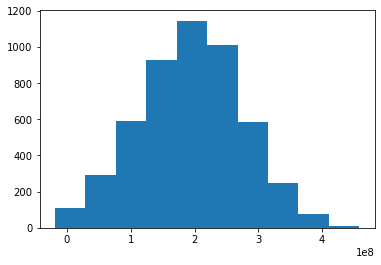

In [14]:
from matplotlib import pyplot
pyplot.hist([s.fit for s in samples_p])

##### train a proxy model

In [15]:
args.train_ratio = 0.7
args.validate_ratio = 0.15
args.train_model_saved_dir = './model/1'

args.num_of_epochs = 20
args.batch_size = 150
model_name = 'ResNet'
# args.input_flag = ['TOFP','TOFI','Pressure']

In [16]:
Model_p = ProxyModel(args, samples_p, model_name=model_name)
if os.path.exists(f'{Model_p.saved_dir}/saved_model.pth'):
    Model_p.model.load_state_dict(torch.load(f'{Model_p.saved_dir}/saved_model.pth'))
else:
    Model_p.model = Model_p.train_model(samples_p, train_ratio=args.train_ratio,
                                        validate_ratio=args.validate_ratio,
                                        saved_dir=Model_p.saved_dir)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

##### plot "real-prediction"

In [ ]:
from matplotlib import pyplot
real = Model_p.reals
prediction = Model_p.predictions
pyplot.scatter(real, prediction)


#### 1.2. Optimization


In [ ]:
args.optimization_algorithm = 'PSO'
args.num_of_generations = 10

In [ ]:
placement_positions = PlacementSample.make_candidate_solutions(num_of_candidates=args.num_of_particles)

WPO = GlobalOpt(args, placement_positions, [PlacementSample.perm[idx[0]-1] for idx in PlacementSample.perm_idx],
                alg_name='PSO', nn_model=Model_p, sample=samples_p)
WPO.iterate(args.num_of_generations)
best_wp = WPO.get_solution(location=True, type=True)

### 2. Well operation


#### 2.1. Proxy modeling

##### make samples to train a proxy model


In [ ]:
OperationSample = DataSampling(args, wset=args.well_operation_wset, well_type=args.well_type,
                                       type_fix=True, location_fix=True, drilling_time_fix=False,
                                       control_fix=False, num_of_ensemble=args.num_of_ensemble,
                                       num_of_wells=len(best_wp['location']), violation_check=False)

if os.path.exists(os.path.join(args.cached_dir, args.well_operation_sample_file)):
    with open(args.cached_file, 'rb') as f:
        samples_o = pickle.load(f)
else:
    args.drilling_cost = 2E+06
    initial_o = OperationSample.make_candidate_solutions(num_of_candidates=args.num_of_train_sample,
                                                         location=best_wp['location'],
                                                         type_real=best_wp['type'])
    samples_o = OperationSample.make_train_data(initial_o, [perm[idx[0] - 1] for idx in perm_idx],
                                                use_frontsim=False)
    with open(os.path.join(args.cached_dir, args.well_operation_sample_file), 'wb') as f:
        pickle.dump(samples_o, f)

##### NPV histogram

In [ ]:
from matplotlib import pyplot
pyplot.hist([s.fit for s in samples_o])

##### train a proxy model

In [ ]:
Model_o = ProxyModel(args, samples_o, model_name='LSTM')
if os.path.exists(f'{Model_o.saved_dir}/saved_model.pth'):
    Model_o.model.load_state_dict(torch.load(f'{Model_o.saved_dir}/saved_model.pth'))
else:
    Model_o.model = Model_o.train_model(samples_o, train_ratio=args.train_ratio,
                                        validate_ratio=args.validate_ratio,
                                        saved_dir=Model_o.saved_dir)

##### plot "real-prediction"

In [ ]:
from matplotlib import pyplot
real = Model_o.reals
prediction = Model_o.predictions
pyplot.scatter(real, prediction)

#### 2.2. Optimization

In [ ]:
operation_positions = OperationSample.make_candidate_solutions(num_of_candidates=args.num_of_particles)

WOO = GlobalOpt(args, operation_positions, OperationSample.perm[:, OperationSample.perm_idx - 1],
                alg_name='PSO', nn_model=Model_o, sample=samples_p)
WOO.iterate(args.num_of_generations)
best_wo = WOO.get_solution(drilling_time=True, control=True)